In [1]:
import sympy as smp
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA # Principal component analysis
import torch # Neural network training and inference
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from numpy.linalg import eig
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import patsy
from matplotlib.colors import ListedColormap, BoundaryNorm

# Parameters which AI Poincare and PullNN classes are using for inference
PREPROCESS_EIGENVALUE_THRESHOLD = 0.001 # Threshold for linear invariant
PULLNN_HIDDEN_LAYERS = [256,256] # Pull NN hidden layers
PULLNN_LEAKYRELU_SLOPE = 0 # Slope for the Leaky Rectified Linear Unit
PULLNN_OPTIMIZER_TYPE = 'Adam' # Either Adam or SGD
PULLNN_LEARNING_RATE = 0.001 # Learning rate for optimization
PULLNN_BATCH_SIZE = 1024 # Batch size for training
PULLNN_TRAIN_ITER = 500 # Number of training iterations
PULLNN_TRAIN_LOGITER = 200 # Log after every given number of iterations
NEFF_NPOINTS = 100 # Number of starting points for estimating Neff
NEFF_WALK_STEPS = 2000 # Number of random walk steps to estimate Neff
NEFF_FORMULA_A = 2

In [2]:
pi = smp.symbols(r'\pi')
t, g = smp.symbols('t, g')
m1, m2 = smp.symbols('m1, m2')
L = smp.symbols('L')

the, phi = smp.symbols(r'\theta , \phi', cls=smp.Function)
alp = smp.symbols(r'\alpha', cls=smp.Function)

the = the(t)
phi = phi(t)
alp = alp(t)
bet = L-alp

thed = smp.diff(the, t)
phid = smp.diff(phi, t)
thedd = smp.diff(thed, t)
phidd = smp.diff(phid, t)
alpd = smp.diff(alp, t)
betd = smp.diff(bet, t)
alpdd = smp.diff(alpd, t)
betdd = smp.diff(betd, t)

In [3]:
xc1 = -alp*smp.sin(phi)
yc1 = -alp*smp.cos(phi)
xc2 =  bet*smp.sin(the)
yc2 = -bet*smp.cos(the)

xc1d = smp.diff(xc1,t)
yc1d = smp.diff(yc1,t)
xc2d = smp.diff(xc2,t)
yc2d = smp.diff(yc2,t)

lagrangian = m1*(betd**2 + bet**2*phid**2)/2 + m2*(alpd**2 + alp**2*thed**2)/2 - m1*g*(alp + bet*(1-smp.cos(phi))) + m2*g*alp*smp.cos(the)

In [4]:
LE1 = smp.diff(lagrangian, the) - smp.diff(smp.diff(lagrangian, thed), t).simplify()
LE2 = smp.diff(lagrangian, phi) - smp.diff(smp.diff(lagrangian, phid), t).simplify()
LE3 = smp.diff(lagrangian, alp) - smp.diff(smp.diff(lagrangian, alpd), t).simplify()

sols = smp.solve([LE1, LE2, LE3], (thedd, phidd, alpdd),
                simplify=True, rational=False)

In [5]:
dk1dt_f = smp.lambdify((t,g,m1,m2,L,pi,the,phi,thed,phid,alp,alpd), sols[thedd])
dk2dt_f = smp.lambdify((t,g,m1,m2,L,pi,the,phi,thed,phid,alp,alpd), sols[phidd])
dk3dt_f = smp.lambdify((t,g,m1,m2,L,pi,the,phi,thed,phid,alp,alpd), sols[alpdd])
dthedt_f = smp.lambdify(thed, thed)
dphidt_f = smp.lambdify(phid, phid)
dalpdt_f = smp.lambdify(alpd, alpd)

In [6]:
parameters = [10,1,1,100,np.pi] # g,m1,m2,L,pi

def system(t,variables):
    
    g,m1,m2,L,pi = parameters
    the,z1,phi,z2,alp,z3 = variables
    
    return [
        
        dthedt_f(z1),
        dk1dt_f(t,g,m1,m2,L,pi,the,phi,z1,z2,alp,z3),
        dphidt_f(z2),
        dk2dt_f(t,g,m1,m2,L,pi,the,phi,z1,z2,alp,z3),
        dalpdt_f(z3),
        dk3dt_f(t,g,m1,m2,L,pi,the,phi,z1,z2,alp,z3)
        
    ]

In [7]:
def runge_kutta_45_system_second_order(tmin, in_cons, dt, tmax):
    
    t_values = [tmin]
    variable_values = [in_cons]

    num_steps = int((tmax - tmin) / dt)

    for _ in range(num_steps):
        t = t_values[-1]
        variables = variable_values[-1]

        k1 = np.multiply(dt, system(t, variables))
        k2 = np.multiply(dt, system(t + 1/4 * dt, np.add(variables, 1/4 * k1)))
        k3 = np.multiply(dt, system(t + 3/8 * dt, np.add(variables, 3/32 * k1 + 9/32 * k2)))
        k4 = np.multiply(dt, system(t + 12/13 * dt, np.add(variables, 1932/2197 * k1 - 7200/2197 * k2 + 7296/2197 * k3)))
        k5 = np.multiply(dt, system(t + dt, np.add(variables, 439/216 * k1 - 8 * k2 + 3680/513 * k3 - 845/4104 * k4)))
        k6 = np.multiply(dt, system(t + 1/2 * dt, np.add(variables, -8/27 * k1 + 2 * k2 - 3544/2565 * k3 + 1859/4104 * k4 - 11/40 * k5)))

        variables_new = np.add(variables, 25/216 * k1 + 1408/2565 * k3 + 2197/4104 * k4 - 1/5 * k5)

        t_values.append(t + dt)
        variable_values.append(variables_new)
        

    return t_values, variable_values

In [8]:
tmin = 0
in_cons = [0.4,0,0.41,0,45,0]  # [the,dthedt,phi,dphi,dt]
dt = 0.1  # Step size
tmax = 300  # End time

In [9]:
t_values, variable_values = runge_kutta_45_system_second_order(tmin, in_cons, dt, tmax)
the_values, thed_values, phi_values, phid_values, alp_values, alpd_values= np.array(variable_values).T


In [11]:
dat = []
dat.append(the_values)
dat.append(thed_values)
dat.append(phi_values)
dat.append(phid_values)
dat.append(alp_values)
dat.append(alpd_values)
data = np.array(dat).T

In [12]:
from aipoincare1_lib import AIPoincare
som = AIPoincare(data)
Larray = np.logspace(0,2.3,10)/100
som.run(Larray)

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!


[0.         0.         0.         0.         0.94647926 2.467323
 2.548757   1.6934553  0.75544417 0.10390357]


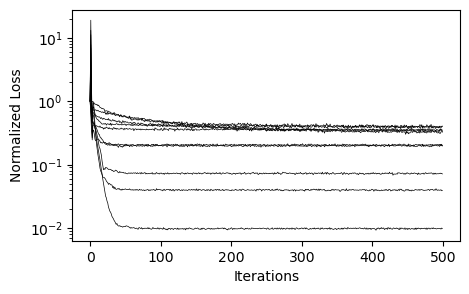

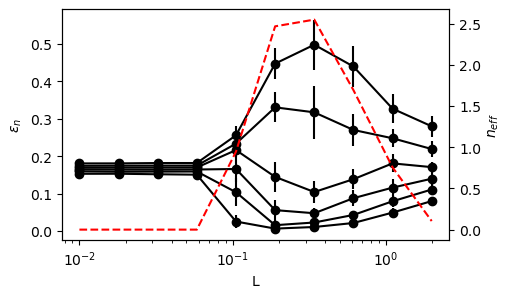

In [13]:
som.plot_mseloss(plt)
som.plot_exp_ratio_diagram(plt)
plt.savefig('two_bod_trj.pdf')

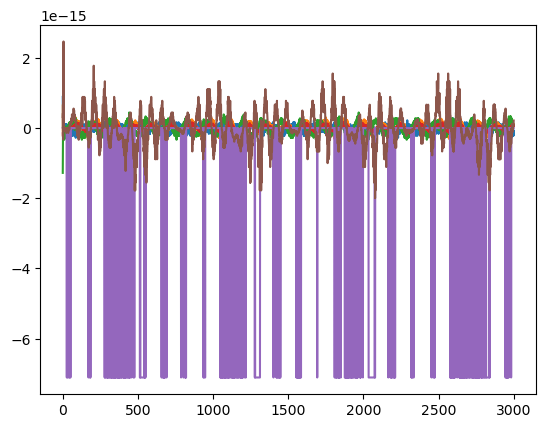

In [14]:
###########################################################################################################################
# Prewhitening part of the algorithm
PREPROCESS_EIGENVALUE_THRESHOLD = 0.001

# Step 1: Normalized trajectory
mean_trajectory_data = np.mean(data, axis=0)
std_trajectory_data = np.std(data, axis=0)
trajectory_data_normalized0 = (data -
                mean_trajectory_data[np.newaxis,:])\
                        /std_trajectory_data

# Step 2: Principal Component Analysis to extract linear invariants
pca = PCA() # Get the PCA object
transformed_data = pca.fit_transform(trajectory_data_normalized0)
eigs_above_threshold = np.sum(pca.explained_variance_ratio_
                    > PREPROCESS_EIGENVALUE_THRESHOLD)
data1 = transformed_data[:,:eigs_above_threshold]
std_data = np.std(transformed_data,axis=0)
change_of_basis = pca.components_
inverse = np.linalg.inv(change_of_basis)


# Step 3: Scaling again for isotropy
trajectory_data_normalized = transformed_data/(std_data[np.newaxis,:]+PREPROCESS_EIGENVALUE_THRESHOLD)
###########################################################################################################################
# From transformed data to raw data
data_before_final_scaling = trajectory_data_normalized*(std_data[np.newaxis,:]+PREPROCESS_EIGENVALUE_THRESHOLD)
data_before_pca = np.matmul(inverse,data_before_final_scaling.T).T
data_before_transformations = data_before_pca*std_trajectory_data+mean_trajectory_data[np.newaxis,:]

w = trajectory_data_normalized*(std_data[np.newaxis,:]+PREPROCESS_EIGENVALUE_THRESHOLD)
ww = np.matmul(inverse,w.T).T
www = ww*(std_trajectory_data)+mean_trajectory_data[np.newaxis,:]

must_be_zero = data_before_transformations-data
dim0 = must_be_zero.shape[0]
dim1 = must_be_zero.shape[1]
x_axis = np.zeros(dim0)
plt.plot(must_be_zero)

In [15]:
nnwidths = som.nn_widths # Neural network architecture
ndims = som.ndim # Number of dimensions
npts = som.npts # Number of points in the data
inf = som.nn_state_dict_list # Some information of trained neural network
dt = 1
range_of_jj = int(dim0/dt)

from aipoincare1_lib import PullNN

pullnn = PullNN(nnwidths) # Set up a fresh network
pullnn.load_state_dict(inf[6])

<All keys matched successfully>

In [16]:
eigenvalues = []

svss = []

for jj in range(len(data)): # Iterate to choose random points
    
    ########################################################################################################################
    perturb = torch.normal(0, Larray[3], size = (NEFF_WALK_STEPS,
        dim1), dtype=torch.float)
    # Create a bunch of points in the neighborhood
    x0 = torch.tensor(trajectory_data_normalized[jj], dtype=torch.float) + perturb
    # Try to walk all the points back to the manifold and convert the
    # torch tensor to numpy matrix data where required.
    # The Pull Network calculates the distance to the closest point in the
    # manifold. So to get back to the manifold we need to add x0. This is
    # different from how the paper is phrased. Not sure why this helps.
    pull_back = pullnn(x0).detach() # Detach from the network
    # Pull back all points to the local tangent plane.
    x0 = x0 + pull_back
    x1 = x0.tolist()
    
    #Convert data to nonscaled case for checking the invariants
    # 1)scaling, 2)pca, 3)scaling again
    # Have to go back from where we began
    #x11 = np.array(x1)*(std_data[np.newaxis,:]+PREPROCESS_EIGENVALUE_THRESHOLD)
    #x12 = np.matmul(inverse,x11.T).T
    #x2 = x12*(std_trajectory_data)+mean_trajectory_data[np.newaxis,:]
    
    # Step 3: Find the dimensionality of the local set of points
    pca = PCA() # Declare a Principal Component Analysis object
    pca.fit(x1) # Try to fit to the trajectory data
    svs = pca.singular_values_ # Get the eigenvalues
    #neff = []
    svss.append(svs**2/np.sum(svs**2))
    #for i in range(len(svss)):
    #    if svss[i]>0.001:
    #        neff.append(svss[i])
    ########################################################################################################################
    
    if jj%1000==0:
        print(jj)
    
eigs = np.array(eigenvalues)
lambdas = np.mean(eigs,axis=0)

0
1000
2000
3000


C:\Users\User\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [17]:
eggs = np.array(svss)

In [18]:
final = []
for i in range(len(eggs)):
    eigsabove = []
    for j in range(len(eggs[0])):
        if eggs[i][j]<0.015:
            eigsabove.append(eggs[i][j])
    length = len(eigsabove)
    final.append(length)
neff = np.array(final)

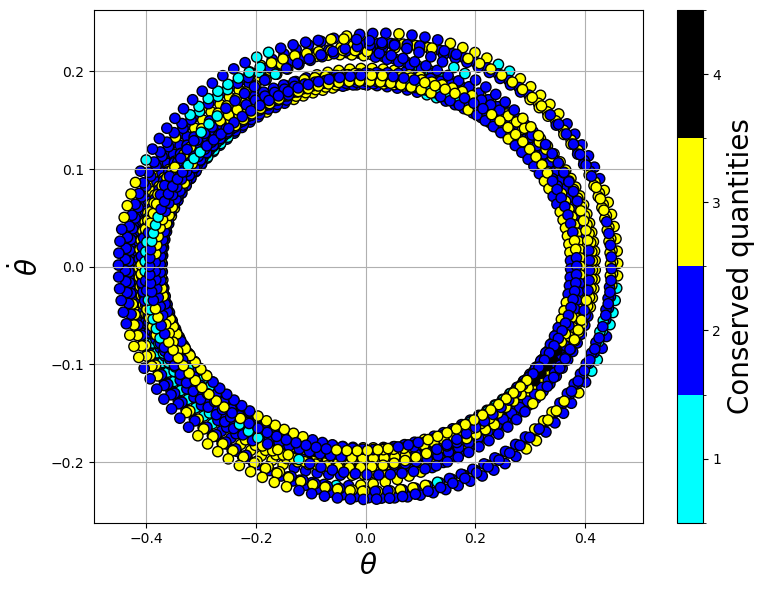

In [19]:
# Define custom colors for each value of y
colors = ['cyan', 'blue', 'yellow', 'black']
cmap = ListedColormap(colors)

boundaries = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

plt.figure(figsize=(8, 6))
sc = plt.scatter(the_values, thed_values, c=neff, cmap=cmap, edgecolors='k',s=55, norm=norm)
cbar=plt.colorbar(sc, ticks=[1, 2, 3, 4], label='Conserved quantities')
cbar.ax.yaxis.label.set_fontsize(20)
# Plot the predicted surface
plt.xlabel(r'$\theta$', fontsize=20)
plt.ylabel(r'$\dot{\theta}$', fontsize=20)
#plt.title('Local dimensionality')
plt.grid(True)
#plt.legend()
plt.tight_layout()

plt.savefig('ps_thed_the.pdf')

plt.show()

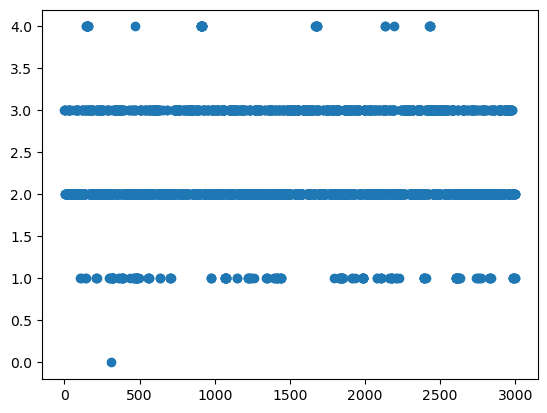

In [20]:
plt.scatter(range(len(neff)),neff)

In [21]:
reg_phid=[]
reg_thed=[]
for i in range(len(neff)):
    if neff[i]>2:
        reg_phid.append(phi_values[i])
        reg_thed.append(the_values[i])
region_phid = np.array(reg_phid)  
region_thed = np.array(reg_thed) 

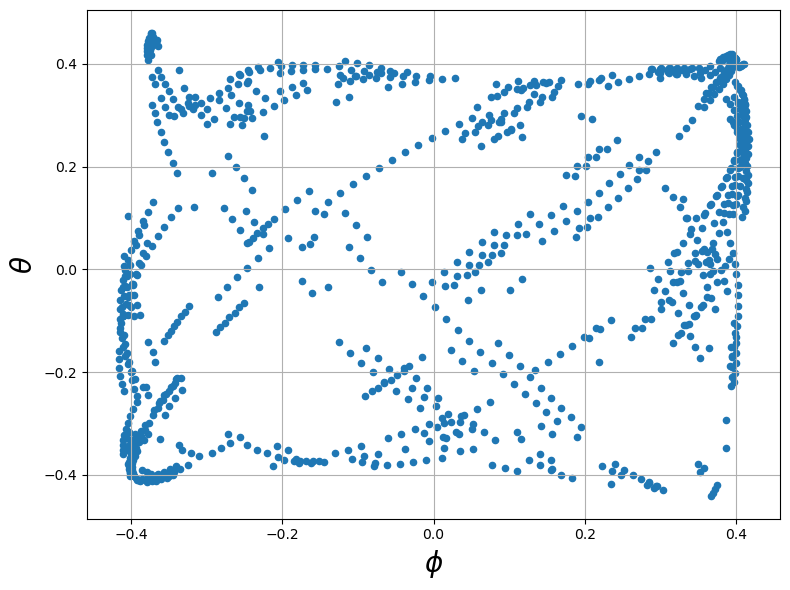

In [22]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(region_phid, region_thed, s=20)

plt.xlabel(r'$\phi$', fontsize=20)
plt.ylabel(r'$\theta$', fontsize=20)
plt.grid(True)
#plt.legend()
plt.tight_layout()
#plt.savefig('int_phi_the.pdf')
plt.show()

In [23]:
neff

array([3, 3, 3, ..., 2, 2, 2])